In [1]:
import matplotlib.pyplot as plt
import random as rdn
import numpy as np
import scipy
import math
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.integrate import quad
from scipy.integrate import solve_ivp
from iminuit import Minuit
import pandas as pd
import time 


#importation des donnés
df = pd.read_csv("fsigma8_data.dat", sep=";")

z_data = np.array((df['z'].copy()).tolist())
fsig8 = np.array((df['fsig8'].copy()).tolist())
fsig8_err_minus = np.array((df['fsig8_err_minus'].copy()).tolist())
fsig8_err_plus = np.array((df['fsig8_err_plus'].copy()).tolist())


"""
z_start = 2
z_end = 0
step = 1e-4
nb_sample = int(np.abs(z_end - z_start) / step) + 1
z_ = np.linspace(z_start,z_end,nb_sample)"""
"""def tri_f_simu(z_,fsol):
    
    f_sim = np.array([])
    z_ = np.round(z_,3)
    
    for element in z_data:
    
        for i in range(1,len(z_)):
            if element == z_[i] and z_[i-1] != z_[i]:
                f_sim = np.append(f_sim,fsol[i-1])
                
    f_sim =  np.abs(f_sim)
    return f_sim        """

def gamma(w, Omega):
    
    return (3*(w-1))/(6*w-5)  #- (15/2057)*np.log(omega_m(z,omega_m0))

def omega_m(z,omega_m0):
    a = 1/(1+z)
    return (omega_m0*(1/(omega_m0+(1-omega_m0)*a**3)))

def omega_mGamma(z,gamma,omega_m0,w):
    #a = 1/(1+z)
    return (omega_m0*(1/(omega_m0+(1-omega_m0)*(1+z)**(3*w))))**gamma
    
    
def siga8bis(omega_m0,sigma8_0):
    return sigma8_0*np.sqrt(0.3/omega_m0)
    
def func(z, omega_m0,w):
    return omega_mGamma(z,gamma(w,omega_m0),omega_m0,w)/(1+z)
    
def D_z(omega_m0,z,w):
    # Créer une fonction pour l'intégration
    result, error = quad(func,0,z,args =(omega_m0,w))
    return np.exp(-result)
    
def sigma8(sigma8_0,omega_m0,z,w):
    return sigma8_0*D_z(omega_m0,z,w)
    
def Chi2(omega_m0,sigma8_0,w):
    
    chi2 = 0
    #f_simu = tri_f_simu(z_, omega_mGamma(z_,gamma(omega_m0,w),omega_m0,w))
    f_simu = omega_mGamma(z_data,omega_m0,gamma(w,omega_m0),w)
    for i in range(len(fsig8)): 
        
        residual = fsig8[i] - f_simu[i]*sigma8(sigma8_0,omega_m0,z_data[i],w)
        sigma = fsig8_err_plus[i] if residual >= 0 else fsig8_err_minus[i]
        chi2 += (residual/sigma)**2
    #chi2 += ((sigma8_0*(omega_m0/0.3)**(1/2)-0.81)**2)/(0.01)**2  + ((omega_m0 - 0.334)**2)/(0.018)**2   
    return chi2

minimizer = Minuit(Chi2, omega_m0=0.3, sigma8_0=0.7,w=-1)
minimizer.limits["omega_m0"] = (0,1)
minimizer.limits["sigma8_0"] = (0,1)  # Valeurs plus physiques
minimizer.fixed["w"] = True
minimizer.errordef = 1.0  # Pour chi2
minimizer.strategy = 2    # Plus précis
result = minimizer.migrad()
print(result)

# Statistiques du fit
chi2_val = minimizer.fval
ndof = len(fsig8) - len(minimizer.parameters)
chi2_reduit = chi2_val / ndof

print(f"\nRésultats du fit :")
print(f"Chi2 = {chi2_val:.2f}")
print(f"Nombre de degrés de liberté = {ndof}")
print(f"Chi2 réduit = {chi2_reduit:.2f}")
print(f"Paramètres estimés :")
print(f"Ωm = {minimizer.values['omega_m0']:.3f} ± {minimizer.errors['omega_m0']:.3f}")
print(f"σ8,0 = {minimizer.values['sigma8_0']:.3f} ± {minimizer.errors['sigma8_0']:.3f}")
print(f"w = {minimizer.values['w']:.3f} ± {minimizer.errors['w']:.3f}")



┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 12.28                      │              Nfcn = 132              │
│ EDM = 7.33e-08 (Goal: 0.0002)    │            time = 0.1 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │   Below EDM threshold (goal x 10)    │
├──────────────────────────────────┼──────────────────────────────────────┤
│     SOME parameters at limit     │           Below call limit           │
├──────────────────────────────────┼──────────────────────────────────────┤
│             Hesse ok             │         Covariance accurate          │
└──────────────────────────────────┴──────────────────────────────────────┘
┌───┬──────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬──

<>:17: SyntaxWarning: invalid escape sequence '\s'
<>:17: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Redouane\AppData\Local\Temp\ipykernel_852\3357151350.py:17: SyntaxWarning: invalid escape sequence '\s'
  plt.title('Fit $f\sigma_8$ (approximation analytique)')


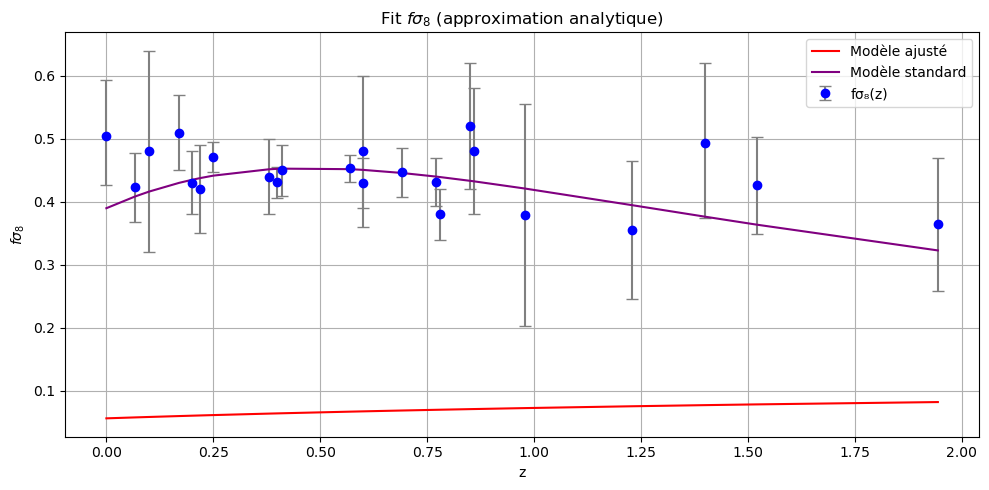

In [9]:
omega_m0_fit = minimizer.values["omega_m0"]
sigma8_0_fit = minimizer.values["sigma8_0"]
w_fit = minimizer.values["w"]

gamma_fit = gamma(omega_m0_fit,w_fit)
modele = omega_mGamma(z_data, gamma_fit, omega_m0_fit,w_fit) * np.array([sigma8(sigma8_0_fit, omega_m0_fit, z,w_fit) for z in z_data])
gamma_modele_standard = gamma(0.334, -1)
modele_standard = omega_mGamma(z_data, gamma_modele_standard, 0.334,-1) * np.array([sigma8(0.81,0.334, z,-1) for z in z_data])

# --- Plot 1 : Fit et données ---
plt.figure(figsize=(10, 5))
plt.errorbar(z_data, fsig8, yerr=[fsig8_err_minus, fsig8_err_plus], fmt='o', ecolor='gray', elinewidth=1.5, capsize=4, label="fσ₈(z)", color='blue')
plt.plot(z_data, modele, 'r-', label='Modèle ajusté')
plt.plot(z_data, modele_standard, color='purple', linestyle='-', label='Modèle standard')
plt.xlabel('z')
plt.ylabel(r'$f\sigma_8$')
plt.title('Fit $f\sigma_8$ (approximation analytique)')
plt.legend()
plt.grid(True)
plt.tight_layout()

In [10]:

# --- Grille pour les contours χ² ---
N = 100
omega_m0_vals = np.linspace(0.2,0.4,N)
sigma8_0_vals = np.linspace(0.5,2,N)
w_vals = np.linspace(-0.5,0.5,N)

# On va projeter sur chaque plan 2D en fixant le troisième paramètre à sa valeur best-fit
chi2_grid_om_s8 = np.zeros((len(omega_m0_vals), len(sigma8_0_vals)))
chi2_grid_om_w = np.zeros((len(omega_m0_vals), len(w_vals)))
chi2_grid_s8_w = np.zeros((len(sigma8_0_vals), len(w_vals)))

# Best-fit
om_best = minimizer.values['omega_m0']
s8_best = minimizer.values['sigma8_0']
w_best = minimizer.values['w']

# --- Calcul des grilles ---
print("Début du calcul des grilles χ² pour le triplot...")

print("Calcul grille Ωm0 vs S8 (w fixé)...")
start_om_s8 = time.time()
for i, om in enumerate(omega_m0_vals):
    for j, s8 in enumerate(sigma8_0_vals):
        chi2_grid_om_s8[i, j] = Chi2(om, s8, w_best)
end_om_s8 = time.time()
print(f"...Grille Ωm0 vs S8 terminée. Temps : {end_om_s8 - start_om_s8:.2f} s")

print("Calcul grille Ωm0 vs w (σ8 fixé)...")
start_om_w = time.time()
for i, om in enumerate(omega_m0_vals):
    for k, w_ in enumerate(w_vals):
        chi2_grid_om_w[i, k] = Chi2(om, s8_best, w_)
end_om_w = time.time()
print(f"...Grille Ωm0 vs w terminée. Temps : {end_om_w - start_om_w:.2f} s")

print("Calcul grille σ8 vs w (Ωm0 fixé)...")
start_s8_w = time.time()
for j, s8 in enumerate(sigma8_0_vals):
    for k, w_ in enumerate(w_vals):
        chi2_grid_s8_w[j, k] = Chi2(om_best, s8, w_)
end_s8_w = time.time()
print(f"...Grille σ8 vs w terminée. Temps : {end_s8_w - start_s8_w:.2f} s")

Début du calcul des grilles χ² pour le triplot...
Calcul grille Ωm0 vs S8 (w fixé)...
...Grille Ωm0 vs S8 terminée. Temps : 7.53 s
Calcul grille Ωm0 vs w (σ8 fixé)...
...Grille Ωm0 vs w terminée. Temps : 8.60 s
Calcul grille σ8 vs w (Ωm0 fixé)...
...Grille σ8 vs w terminée. Temps : 8.60 s


In [11]:
chi2_grid_om_s8_ms = np.zeros((len(omega_m0_vals), len(sigma8_0_vals)))
chi2_grid_om_w_ms = np.zeros((len(omega_m0_vals), len(w_vals)))
chi2_grid_s8_w_ms = np.zeros((len(sigma8_0_vals), len(w_vals)))

# contour modele standards
om_ms = 0.334
s8_ms = 0.81
w_ms = -1

# --- Calcul des grilles ---
print("Début du calcul des grilles χ² pour le triplot...")

print("Calcul grille Ωm0 vs S8 (w fixé)...")
start_om_s8 = time.time()
for i, om in enumerate(omega_m0_vals):
    for j, s8 in enumerate(sigma8_0_vals):
        chi2_grid_om_s8_ms[i, j] = Chi2(om, s8, w_ms)
end_om_s8 = time.time()
print(f"...Grille Ωm0 vs S8 terminée. Temps : {end_om_s8 - start_om_s8:.2f} s")

print("Calcul grille Ωm0 vs w (σ8 fixé)...")
start_om_w = time.time()
for i, om in enumerate(omega_m0_vals):
    for k, w_ in enumerate(w_vals):
        chi2_grid_om_w_ms[i, k] = Chi2(om, s8_ms, w_)
end_om_w = time.time()
print(f"...Grille Ωm0 vs w terminée. Temps : {end_om_w - start_om_w:.2f} s")

print("Calcul grille σ8 vs w (Ωm0 fixé)...")
start_s8_w = time.time()
for j, s8 in enumerate(sigma8_0_vals):
    for k, w_ in enumerate(w_vals):
        chi2_grid_s8_w_ms[j, k] = Chi2(om_ms, s8, w_)
end_s8_w = time.time()
print(f"...Grille σ8 vs w terminée. Temps : {end_s8_w - start_s8_w:.2f} s")


# --- Niveaux pour les contours (Δχ² pour 2 paramètres libres) ---
levels = [minimizer.fval + d for d in [2.30, 6.18, 11.83]]  # 1σ, 2σ, 3σ



Début du calcul des grilles χ² pour le triplot...
Calcul grille Ωm0 vs S8 (w fixé)...
...Grille Ωm0 vs S8 terminée. Temps : 7.34 s
Calcul grille Ωm0 vs w (σ8 fixé)...
...Grille Ωm0 vs w terminée. Temps : 8.67 s
Calcul grille σ8 vs w (Ωm0 fixé)...
...Grille σ8 vs w terminée. Temps : 8.66 s


Affichage du triplot...


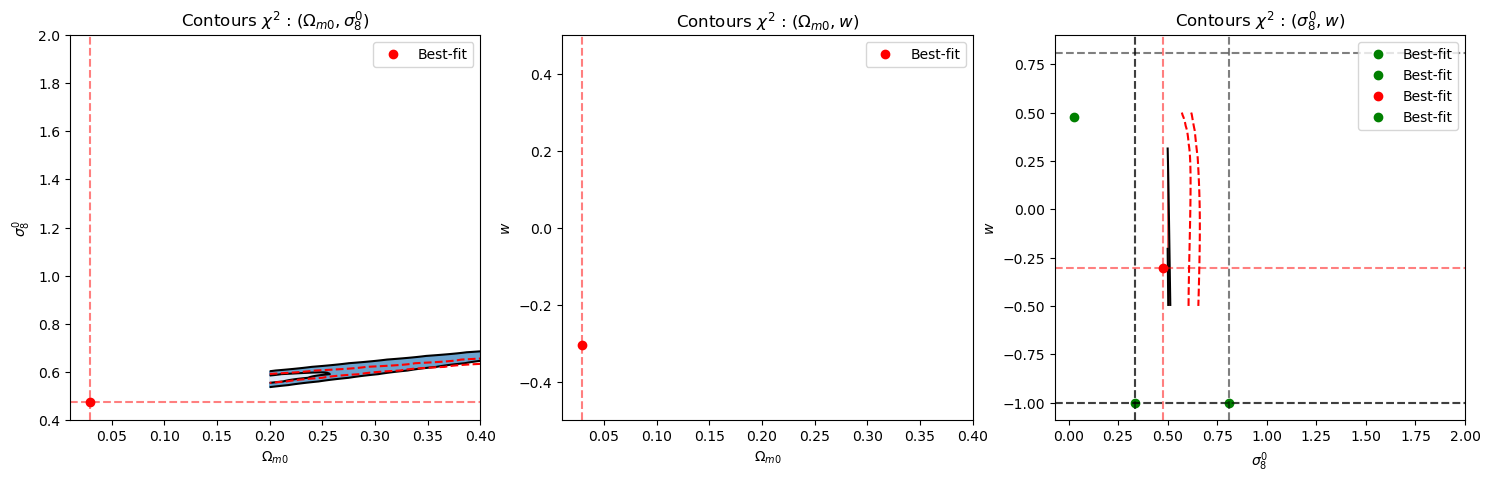

In [12]:
# --- Niveaux pour les contours (Δχ² pour 2 paramètres libres) ---
levels = [minimizer.fval + d for d in [2.30, 6.18, 11.83]]  # 1σ, 2σ, 3σ

# --- Triplot façon FlatΛCDM ---
print("Affichage du triplot...")
fig, axs = plt.subplots(1, 3, figsize=(18, 5))

# Ωm0 vs S8 (w fixé)
cf1 = axs[0].contourf(omega_m0_vals, sigma8_0_vals, chi2_grid_om_s8.T, levels=levels, cmap='Blues', alpha=0.7)
c1 = axs[0].contour(omega_m0_vals, sigma8_0_vals, chi2_grid_om_s8.T, levels=levels, colors='k')
# Contours modèle standard (en tirets rouges)
c1_ms = axs[0].contour(omega_m0_vals, sigma8_0_vals, chi2_grid_om_s8_ms.T, levels=levels, colors='r', linestyles='dashed')
axs[0].plot(om_best, s8_best, 'ro', label='Best-fit')
axs[0].axvline(om_best, color='r', linestyle='--', alpha=0.5)
axs[0].axhline(s8_best, color='r', linestyle='--', alpha=0.5)
axs[2].plot(om_best, s8_best, 'go', label='Best-fit')
axs[2].axvline(om_ms, color='black', linestyle='--', alpha=0.5)
axs[2].axhline(s8_ms, color='black', linestyle='--', alpha=0.5)
axs[0].set_xlabel(r'$\Omega_{m0}$')
axs[0].set_ylabel(r'$\sigma_8^0$')
axs[0].set_title(r'Contours $\chi^2$ : $(\Omega_{m0}, \sigma_8^0)$')
axs[0].legend()
#fig.colorbar(cf1, ax=axs[0], label=r'$\chi^2$')

# Ωm0 vs w (σ8 fixé)
cf2 = axs[1].contourf(omega_m0_vals, w_vals, chi2_grid_om_w.T, levels=levels, cmap='Greens', alpha=0.7)
c2 = axs[1].contour(omega_m0_vals, w_vals, chi2_grid_om_w.T, levels=levels, colors='k')
# Contours modèle standard (en tirets rouges)
c2_ms = axs[1].contour(omega_m0_vals, w_vals, chi2_grid_om_w_ms.T, levels=levels, colors='r', linestyles='dashed')
axs[1].plot(om_best, w_best, 'ro', label='Best-fit')
axs[1].axvline(om_best, color='r', linestyle='--', alpha=0.5)
axs[2].plot(om_ms,w_ms, 'go', label='Best-fit')
axs[2].axvline(om_ms, color='black', linestyle='--', alpha=0.5)
axs[2].axhline(w_ms, color='black', linestyle='--', alpha=0.5)
axs[1].set_xlabel(r'$\Omega_{m0}$')
axs[1].set_ylabel(r'$w$')
axs[1].set_title(r'Contours $\chi^2$ : $(\Omega_{m0}, w)$')
axs[1].legend()
#fig.colorbar(cf2, ax=axs[1], label=r'$\chi^2$')

# σ8 vs w (Ωm0 fixé)
cf3 = axs[2].contourf(sigma8_0_vals, w_vals, chi2_grid_s8_w.T, levels=levels, cmap='Reds', alpha=0.7)
c3 = axs[2].contour(sigma8_0_vals, w_vals, chi2_grid_s8_w.T, levels=levels, colors='k')
# Contours modèle standard (en tirets rouges)
c3_ms = axs[2].contour(sigma8_0_vals, w_vals, chi2_grid_s8_w_ms.T, levels=levels, colors='r', linestyles='dashed')
axs[2].plot(s8_best, w_best, 'ro', label='Best-fit')
axs[2].axvline(s8_best, color='r', linestyle='--', alpha=0.5)
axs[2].axhline(w_best, color='r', linestyle='--', alpha=0.5)
axs[2].plot(s8_ms, w_ms, 'go', label='Best-fit')
axs[2].axvline(s8_ms, color='black', linestyle='--', alpha=0.5)
axs[2].axhline(w_ms, color='black', linestyle='--', alpha=0.5)
axs[2].set_xlabel(r'$\sigma_8^0$')
axs[2].set_ylabel(r'$w$')
axs[2].set_title(r'Contours $\chi^2$ : $(\sigma_8^0, w)$')
axs[2].legend()
#fig.colorbar(cf3, ax=axs[2], label=r'$\chi^2$')

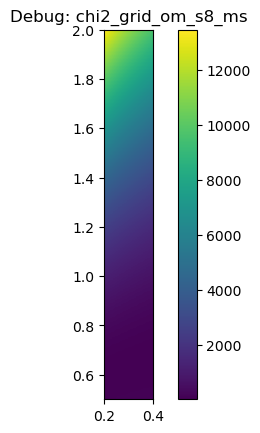

In [13]:
plt.imshow(chi2_grid_om_s8_ms.T, origin='lower', extent=[omega_m0_vals.min(), omega_m0_vals.max(),
                                                         sigma8_0_vals.min(), sigma8_0_vals.max()])
plt.colorbar()
plt.title("Debug: chi2_grid_om_s8_ms")
plt.show()